# ANN code
from chat gpt


### Install and import libraries

In [9]:
# !pip install pandas openpyxl scikit-learn torch


### Import modules


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

### Load and prepare the data from excel
Make sure your Excel file (TEG_data.xlsx) is in the same folder and has column names like:
FF, HTE, HIC, Wn, Wp, ρC, Qin/A, PDmax, η

In [11]:
df = pd.read_csv("5000simulations.csv")  # Replace with your actual filename
print(df.columns.tolist())
df.columns = df.columns.str.strip().str.replace('"', '')
print("Cleaned column names:")
print(df.columns.tolist())


['LHT (mm)', 'HIC (mm)', 'w_p (mm)', 'w_n (mm)', 'FF', 'rho_c', 'Th (K)', 'Electric potential (V), Voc', 'Electric potential (V), Vn', ' PDmax', ' flux (W)']
Cleaned column names:
['LHT (mm)', 'HIC (mm)', 'w_p (mm)', 'w_n (mm)', 'FF', 'rho_c', 'Th (K)', 'Electric potential (V), Voc', 'Electric potential (V), Vn', 'PDmax', 'flux (W)']


In [12]:

# Define input and output columns
input_cols = ['LHT (mm)', 'HIC (mm)', 'w_p (mm)', 'w_n (mm)', 'FF', 'rho_c', 'Th (K)']
output_cols = ['Electric potential (V), Voc', 'Electric potential (V), Vn', 'PDmax', 'flux (W)']

# Extract input and output arrays
X = df[input_cols].values
y = df[output_cols].values

# Standardize data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Normalize X to [0,1] range based on min/max in scaled space
X_min = X_scaled.min(axis=0)
X_max = X_scaled.max(axis=0)
X_normalized = (X_scaled - X_min) / (X_max - X_min)

print('Normalized input shape:', X_normalized.shape)
print('Scaled output shape:', y_scaled.shape)

# Split dataset: training (80%), validation (10%), test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

rho_c_idx = input_cols.index('rho_c')
X[:, rho_c_idx] = np.clip(X[:, rho_c_idx], 1e-9, 1e-7)

Normalized input shape: (4985, 7)
Scaled output shape: (4985, 4)


### Define the ANN model

In [13]:
class TEGModel(nn.Module):
    def __init__(self, input_dim=7, output_dim=4): 
        super(TEGModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# Recreate the model after the change
model = TEGModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Train the model

In [14]:
epochs = 1000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss.item():.6f}, Val Loss = {val_loss.item():.6f}")


Epoch 0: Train Loss = 1.006503, Val Loss = 1.021309
Epoch 100: Train Loss = 0.489789, Val Loss = 0.511328
Epoch 200: Train Loss = 0.385569, Val Loss = 0.408268
Epoch 300: Train Loss = 0.314274, Val Loss = 0.331835
Epoch 400: Train Loss = 0.268839, Val Loss = 0.284080
Epoch 500: Train Loss = 0.239370, Val Loss = 0.257746
Epoch 600: Train Loss = 0.222206, Val Loss = 0.243584
Epoch 700: Train Loss = 0.212018, Val Loss = 0.237070
Epoch 800: Train Loss = 0.205043, Val Loss = 0.232101
Epoch 900: Train Loss = 0.199084, Val Loss = 0.228056


### Evaluate the model

In [15]:
model.eval()
y_pred = model(X_test_tensor)
test_loss = criterion(y_pred, y_test_tensor)
print(f"Test MSE Loss: {test_loss.item():.6f}")


Test MSE Loss: 0.204019


### Correlation between predicted and real values

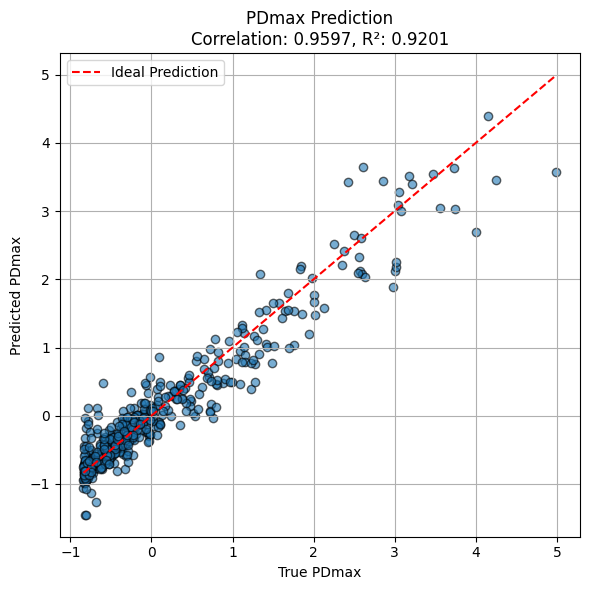

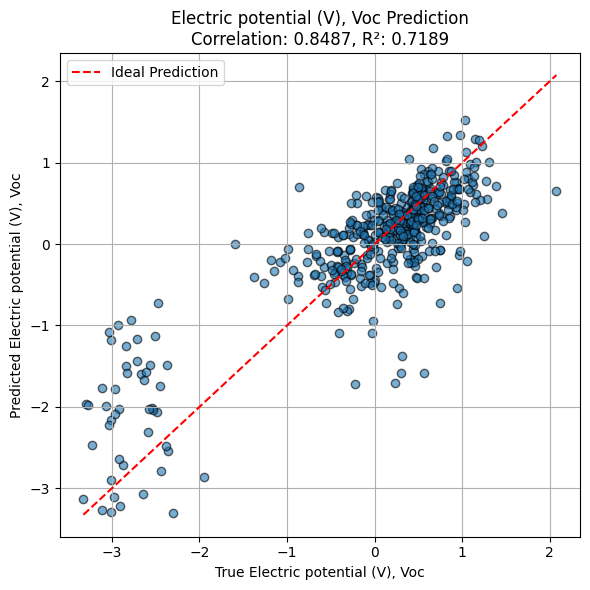

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

# Names and corresponding column indices in y_true / y_predict
output_names = ['Electric potential (V), Voc', 'Electric potential (V), Vn', 'PDmax', 'flux (W)']
selected_outputs = ['PDmax', 'Electric potential (V), Voc']
output_indices = [output_names.index(name) for name in selected_outputs]

# Plot for each selected output
for idx, name in zip(output_indices, selected_outputs):
    # Detach and convert to NumPy arrays
    true_vals = y_test_tensor[:, idx].detach().numpy()
    pred_vals = y_pred[:, idx].detach().numpy()
    
    # Compute correlation coefficient and R²
    corr = np.corrcoef(true_vals, pred_vals)[0, 1]
    r2 = r2_score(true_vals, pred_vals)
    
    # Plotting
    plt.figure(figsize=(6, 6))
    plt.scatter(true_vals, pred_vals, alpha=0.6, edgecolors='k')
    plt.plot([min(true_vals), max(true_vals)],
             [min(true_vals), max(true_vals)], 'r--', label='Ideal Prediction')
    
    plt.xlabel(f"True {name}")
    plt.ylabel(f"Predicted {name}")
    plt.title(f"{name} Prediction\nCorrelation: {corr:.4f}, R²: {r2:.4f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Optimize the values


In [18]:
# Set model to evaluation mode
model.eval()

# Get bounds from the dataset (before scaling)
X_min = df[input_cols].min().values
X_max = df[input_cols].max().values

# Convert bounds to tensors
X_min_tensor = torch.tensor(X_min, dtype=torch.float32)
X_max_tensor = torch.tensor(X_max, dtype=torch.float32)

# Initialize raw parameters for optimization (values in [0, 1] after sigmoid)
param_raw = torch.randn((1, len(input_cols)), dtype=torch.float32, requires_grad=True)

# Optimizer
optimizer = torch.optim.Adam([param_raw], lr=0.05)

# Optimization loop
for step in range(500):
    optimizer.zero_grad()

    # Apply sigmoid to keep values in [0, 1], then rescale to [X_min, X_max]
    bounded_input = torch.sigmoid(param_raw) * (X_max_tensor - X_min_tensor) + X_min_tensor

    # Scale to match training input (use scaler_X from training)
    input_scaled = torch.tensor(scaler_X.transform(bounded_input.detach().numpy()), dtype=torch.float32)

    # Predict using model
    pred_scaled = model(input_scaled)

    # Objective: maximize PDmax (index = 2), so minimize -PDmax
    loss = -pred_scaled[0, 2]  # assuming index 2 is PDmax
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}: Scaled PDmax = {-loss.item():.6f}")

# Final optimized values
bounded_input_final = torch.sigmoid(param_raw).detach() * (X_max_tensor - X_min_tensor) + X_min_tensor
X_opt_real = bounded_input_final.numpy()
y_opt_scaled = model(torch.tensor(scaler_X.transform(X_opt_real), dtype=torch.float32)).detach().numpy()
y_opt_real = scaler_y.inverse_transform(y_opt_scaled)

# Show optimized inputs and outputs
print("\n🔧 Optimized Input Parameters (original units):")
for name, val in zip(input_cols, X_opt_real[0]):
    print(f"{name}: {val:.4f}")

print("\n🚀 Predicted Optimal Outputs:")
for name, val in zip(output_names, y_opt_real[0]):
    print(f"{name}: {val:.4f}")


Step 0: Scaled PDmax = 21.619692
Step 50: Scaled PDmax = 21.619692
Step 100: Scaled PDmax = 21.619692
Step 150: Scaled PDmax = 21.619692
Step 200: Scaled PDmax = 21.619692
Step 250: Scaled PDmax = 21.619692
Step 300: Scaled PDmax = 21.619692
Step 350: Scaled PDmax = 21.619692
Step 400: Scaled PDmax = 21.619692
Step 450: Scaled PDmax = 21.619692

🔧 Optimized Input Parameters (original units):
LHT (mm): 1.4574
HIC (mm): 1.7291
w_p (mm): 2.3769
w_n (mm): 0.9514
FF: 0.5760
rho_c: 0.0000
Th (K): 421.6173

🚀 Predicted Optimal Outputs:
Electric potential (V), Voc: 0.0804
Electric potential (V), Vn: -0.0096
PDmax: 2134.7751
flux (W): 16.0652
